## Modeling a function with two variables by means of fuzzy mathematics

**Purpose:** To model a function with two variables by means of fuzzy logic. Conduct a study of the shape of the membership function on the quality of modeling.

$$ y = \sin{|x|} + \cos{|x|} $$


$$ z = x \cdot \sin{(y)} $$

Let's set intervals for input and output data and present them graphically. Consider the range of x values ​​from 4 to 12.

In [84]:
import numpy as np
from skfuzzy import control, gaussmf, gbellmf, trimf
import plot_script
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
x_values = np.arange(4, 12, 0.1)
y_values = np.sin(np.abs(x_values)) + np.cos(np.abs(x_values))
z_values = x_values * np.sin(y_values)

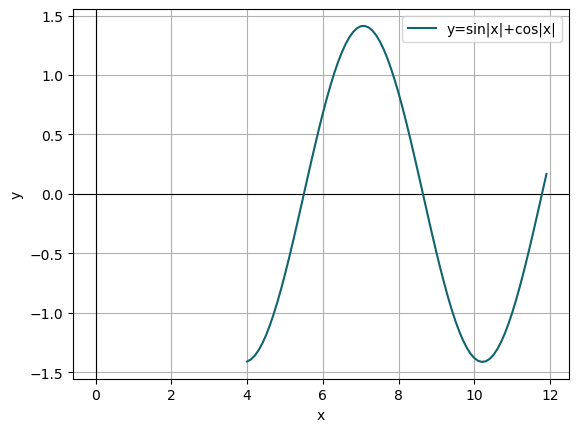

In [9]:
plot_script.plot_graphs(x_values, [{'y': y_values, 'label': 'y=sin|x|+cos|x|', 'color': '#10646e', 'linestyle': '-'}])

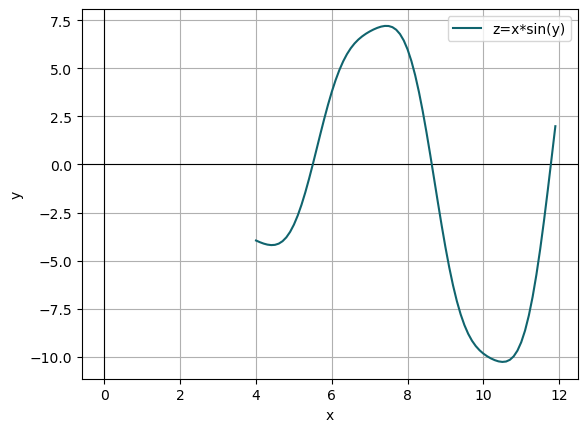

In [14]:
plot_script.plot_graphs(x_values, [{'y': z_values, 'label': 'z=x*sin(y)', 'color': '#10646e', 'linestyle': '-'}])

We divide the data into intervals according to the number of membership functions: x – 6 intervals, y – 6 intervals, z – 9 intervals

In [17]:
def split_intervals(values, num_intervals):
    sorted_values = np.sort(values)

    differences = np.diff(sorted_values)

    intervals = np.array_split(sorted_values, num_intervals)

    interval_ranges = []
    for interval in intervals:
        min_val = min(interval)
        max_val = max(interval)
        mid_val = (min_val + max_val) / 2
        interval_ranges.append((min_val, mid_val, max_val))

    return interval_ranges, differences

In [19]:
def print_intervals(intervals, label):
    print(f'Limits of membership functions {label}:')
    for interval in intervals:
        print(f'[{interval[0]}, {interval[1]}, {interval[2]}]')

In [21]:
x = control.Antecedent(x_values, 'x')
y = control.Antecedent(np.arange(min(y_values), max(y_values), 0.1), 'y')
z = control.Consequent(np.arange(min(z_values), max(z_values), 0.1), 'z')

x_intervals, x_diff = split_intervals(x_values, 6)
print_intervals(x_intervals, 'x')

y_intervals, y_diff = split_intervals(y_values, 6)
print_intervals(y_intervals, 'y')

z_intervals, z_diff = split_intervals(z_values, 9)
print_intervals(z_intervals, 'z')

Limits of membership functions x:
[4.0, 4.649999999999998, 5.299999999999995]
[5.399999999999995, 6.049999999999993, 6.69999999999999]
[6.79999999999999, 7.399999999999988, 7.999999999999986]
[8.099999999999985, 8.699999999999983, 9.299999999999981]
[9.39999999999998, 9.999999999999979, 10.599999999999977]
[10.699999999999976, 11.299999999999974, 11.899999999999972]
Limits of membership functions y:
[-1.4141403396207424, -1.3365376417443395, -1.2589349438679367]
[-1.2479242979915486, -1.0578475999685342, -0.86777090194552]
[-0.7959402432017608, -0.5369166746232537, -0.2778931060447466]
[-0.25453896520077224, 0.040385644385422304, 0.33531025397161685]
[0.42091733752755317, 0.7653257305681159, 1.1097341236086786]
[1.1415420959148759, 1.2775289012417794, 1.413515706568683]
Limits of membership functions z:
[-10.256987875383468, -10.040670561814146, -9.824353248244824]
[-9.668590819677496, -8.757395085713004, -7.846199351748513]
[-7.779963151511064, -5.983862572610071, -4.187761993709078]


#### Creating of membership function

Gauss MF:

In [98]:
def create_gauss_mf(variable, intervals, names):
    for interval, name in zip(intervals, names):
        universe = variable.universe
        variable[name] = gaussmf(universe, interval[1], 0.242)

In [100]:
x_names = ['mx1', 'mx2', 'mx3', 'mx4', 'mx5', 'mx6']
create_gauss_mf(x, x_intervals, x_names)

y_names = ['my1', 'my2', 'my3', 'my4', 'my5', 'my6']
create_gauss_mf(y, y_intervals, y_names)

z_names = ['mf1', 'mf2', 'mf3', 'mf4', 'mf5', 'mf6', 'mf7', 'mf8', 'mf9']
create_gauss_mf(z, z_intervals, z_names)

In [102]:
def make_affiliation_table(x, y, z):
    x_labels = list(x.terms.keys())
    y_labels = list(y.terms.keys())
    z_labels = list(z.terms.keys())

    df_values = pd.DataFrame(index=[f'my{i + 1}' for i in range(len(y_labels))],
                             columns=[f'mx{i + 1}' for i in range(len(x_labels))])

    df_names = pd.DataFrame(index=[f'my{i + 1}' for i in range(len(y_labels))],
                            columns=[f'mx{i + 1}' for i in range(len(x_labels))])

    for i, y_label in enumerate(y_labels):
        for j, x_label in enumerate(x_labels):
            x_universe = x.universe
            y_universe = y.universe
            z_universe = z.universe

            x_mf = x[x_label].mf
            y_mf = y[y_label].mf

            max_x_index = np.argmax(x_mf)
            max_y_index = np.argmax(y_mf)

            max_x_value = x_universe[max_x_index]
            max_y_value = y_universe[max_y_index]

            output_value = max_x_value * max_y_value

            df_values.iloc[i, j] = output_value

            for z_label in z_labels:
                closest_z_index = (np.abs(z.universe - output_value)).argmin()

                z_mf_value = z[z_label].mf[closest_z_index]
                if z_mf_value > 0:
                    df_names.iloc[i, j] = z_label
                    break

    return df_values, df_names

In [104]:
def create_and_print_rules_list(df_names):
    rules = []

    # Iterate through each combination of y (my1 to my6) and x (mx1 to mx6)
    for i, y_label in enumerate(df_names.index):
        for j, x_label in enumerate(df_names.columns):
            # Get the corresponding output label from the df_names
            z_label = df_names.iloc[i, j]
            if z_label:  # Only create a rule if there is a corresponding z label
                # Create a Rule object
                rule = control.Rule(antecedent=(x[x_label] & y[y_label]), consequent=z[z_label])
                rules.append(rule)

                # Print the rule in the specified format
                print(f"if (x is {x_label}) and (y is {y_label}) then (f is {z_label})")

    return rules

F:\Anaconda\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


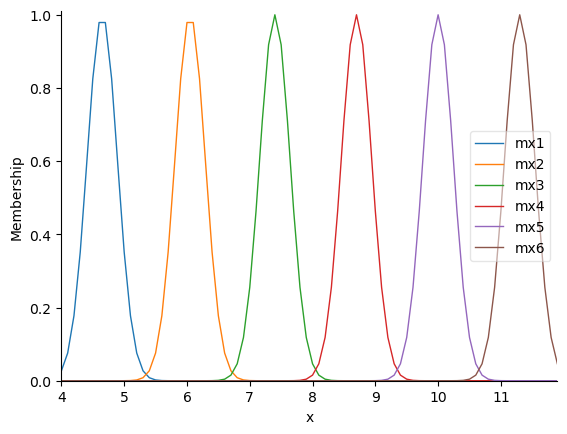

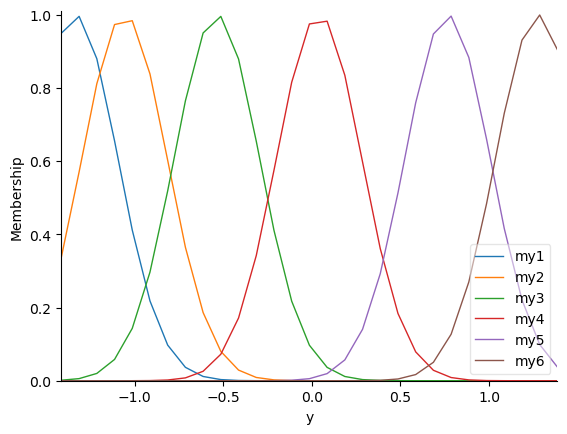

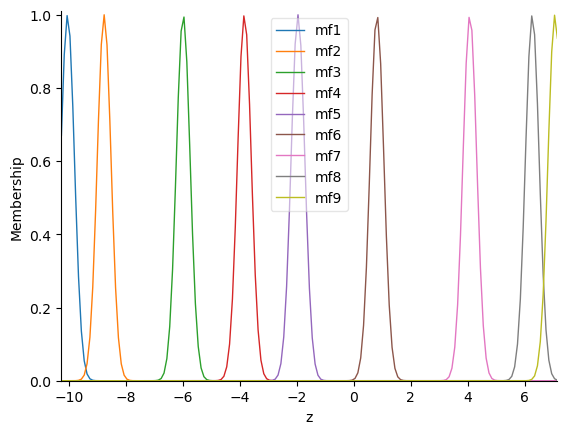

In [106]:
# Plot membership functions for x, y, z
x.view()
y.view()
z.view()

In [49]:
df_values_gauss, df_names_gauss = make_affiliation_table(x, y, z)
print('\nТаблиця значень функцій по максимумам вхідних функцій приналежності:')
print(df_values_gauss)


Таблиця значень функцій по максимумам вхідних функцій приналежності:
          mx1       mx2       mx3        mx4        mx5        mx6
my1 -6.045046 -7.884842 -9.724639 -11.433021 -13.141403 -14.849786
my2 -4.665046 -6.084842 -7.504639  -8.823021 -10.141403 -11.459786
my3 -2.365046 -3.084842 -3.804639  -4.473021  -5.141403  -5.809786
my4  0.394954  0.515158  0.635361   0.746979   0.858597   0.970214
my5  3.614954  4.715158  5.815361   6.836979   7.858597   8.880214
my6  5.914954  7.715158  9.515361  11.186979  12.858597  14.530214


In [51]:
print('\nТаблиця імен функцій:')
print(df_names_gauss)


Таблиця імен функцій:
     mx1  mx2  mx3  mx4  mx5  mx6
my1  mf1  mf1  mf1  mf1  mf1  mf1
my2  mf1  mf1  mf1  mf1  mf1  mf1
my3  mf1  mf1  mf1  mf1  mf1  mf1
my4  mf2  mf2  mf3  mf3  mf3  mf3
my5  mf4  mf4  mf5  mf5  mf5  mf5
my6  mf5  mf5  mf5  mf5  mf5  mf5


In [53]:
print("List of rules:")
rules = create_and_print_rules_list(df_names_gauss)

List of rules:
if (x is mx1) and (y is my1) then (f is mf1)
if (x is mx2) and (y is my1) then (f is mf1)
if (x is mx3) and (y is my1) then (f is mf1)
if (x is mx4) and (y is my1) then (f is mf1)
if (x is mx5) and (y is my1) then (f is mf1)
if (x is mx6) and (y is my1) then (f is mf1)
if (x is mx1) and (y is my2) then (f is mf1)
if (x is mx2) and (y is my2) then (f is mf1)
if (x is mx3) and (y is my2) then (f is mf1)
if (x is mx4) and (y is my2) then (f is mf1)
if (x is mx5) and (y is my2) then (f is mf1)
if (x is mx6) and (y is my2) then (f is mf1)
if (x is mx1) and (y is my3) then (f is mf1)
if (x is mx2) and (y is my3) then (f is mf1)
if (x is mx3) and (y is my3) then (f is mf1)
if (x is mx4) and (y is my3) then (f is mf1)
if (x is mx5) and (y is my3) then (f is mf1)
if (x is mx6) and (y is my3) then (f is mf1)
if (x is mx1) and (y is my4) then (f is mf2)
if (x is mx2) and (y is my4) then (f is mf2)
if (x is mx3) and (y is my4) then (f is mf3)
if (x is mx4) and (y is my4) then (f is 

In [55]:
def creation_of_membership(x, y, z):
    system = control.ControlSystem(rules)

    # Create simulation
    simulation = control.ControlSystemSimulation(system)

    # Store results from the simulation
    results = []

    # Simulate for each combination of x and y values
    for x_val, y_val in zip(x_values, y_values):
        simulation.input['x'] = x_val
        simulation.input['y'] = y_val
        simulation.compute()
        # Get output z
        output = simulation.output['z']
        results.append(output)

    # Plot results with subplot_graphs function
    plot_script.subplot_graphs(x_values, [{'y': results, 'label': 'z=y=sin|x|+cos|x|', 'color': '#10646e', 'linestyle': '-'},
                                          {'y': z_values, 'label': 'z=x*sin(y)', 'color': '#10646e', 'linestyle': '-'}])
    return results

<Figure size 1000x600 with 0 Axes>

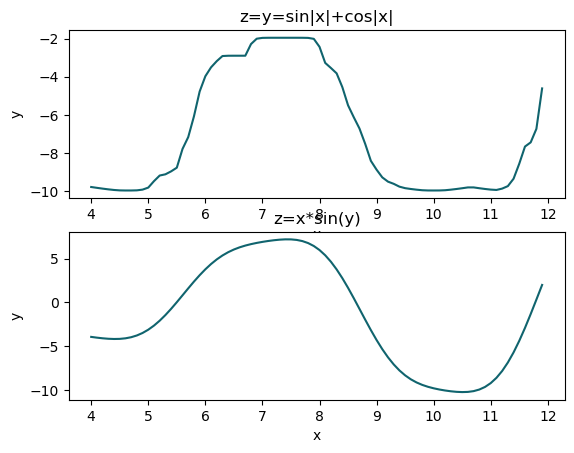

In [57]:
gauss_result = creation_of_membership(x, y, z)

In [66]:
def create_trimf(variable, intervals, names):
    for interval, name in zip(intervals, names):
        universe = variable.universe
        variable[name] = trimf(universe, [(interval[0]-0.8), interval[1], (interval[2]+0.8)])


Triangular MF:

In [68]:
create_trimf(x, x_intervals, x_names)
create_trimf(y, y_intervals, y_names)
create_trimf(z, z_intervals, z_names)

F:\Anaconda\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


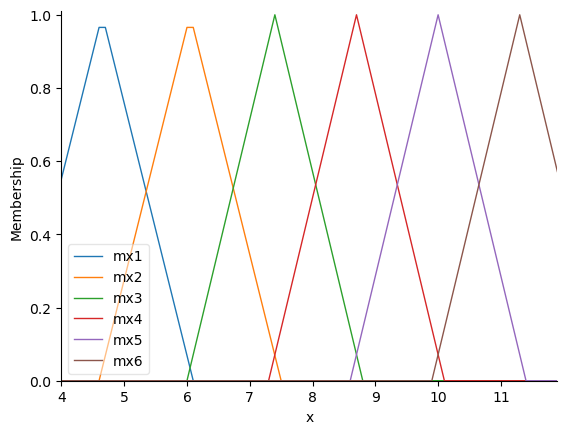

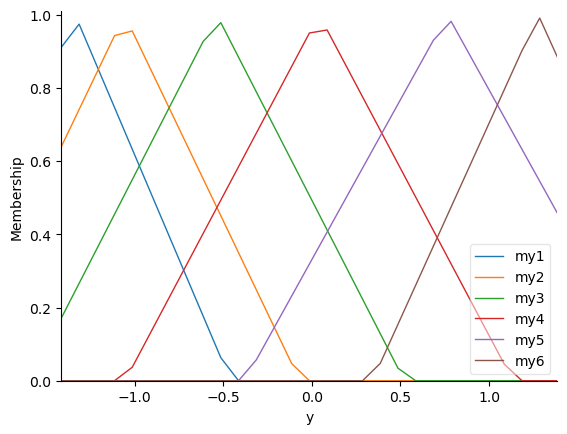

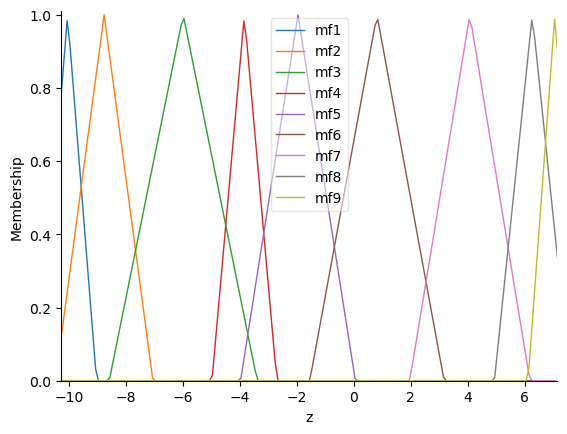

In [70]:
# Plot membership functions for x, y, z
x.view()
y.view()
z.view()

In [72]:
df_values_triangle, df_names_triangle = make_affiliation_table(x, y, z)
print('\nТаблиця значень функцій по максимумам вхідних функцій приналежності:')
print(df_values_triangle)


Таблиця значень функцій по максимумам вхідних функцій приналежності:
          mx1       mx2       mx3        mx4        mx5        mx6
my1 -6.045046 -7.884842 -9.724639 -11.433021 -13.141403 -14.849786
my2 -4.665046 -6.084842 -7.504639  -8.823021 -10.141403 -11.459786
my3 -2.365046 -3.084842 -3.804639  -4.473021  -5.141403  -5.809786
my4  0.394954  0.515158  0.635361   0.746979   0.858597   0.970214
my5  3.614954  4.715158  5.815361   6.836979   7.858597   8.880214
my6  5.914954  7.715158  9.515361  11.186979  12.858597  14.530214


In [74]:
print('\nТаблиця імен функцій:')
print(df_names_triangle)


Таблиця імен функцій:
     mx1  mx2  mx3  mx4  mx5  mx6
my1  mf3  mf2  mf1  mf1  mf1  mf1
my2  mf3  mf3  mf2  mf2  mf1  mf1
my3  mf5  mf4  mf3  mf3  mf3  mf3
my4  mf6  mf6  mf6  mf6  mf6  mf6
my5  mf7  mf7  mf7  mf8  mf8  mf8
my6  mf7  mf8  mf8  mf8  mf8  mf8


In [76]:
print("List of rules:")
rules = create_and_print_rules_list(df_names_triangle)

List of rules:
if (x is mx1) and (y is my1) then (f is mf3)
if (x is mx2) and (y is my1) then (f is mf2)
if (x is mx3) and (y is my1) then (f is mf1)
if (x is mx4) and (y is my1) then (f is mf1)
if (x is mx5) and (y is my1) then (f is mf1)
if (x is mx6) and (y is my1) then (f is mf1)
if (x is mx1) and (y is my2) then (f is mf3)
if (x is mx2) and (y is my2) then (f is mf3)
if (x is mx3) and (y is my2) then (f is mf2)
if (x is mx4) and (y is my2) then (f is mf2)
if (x is mx5) and (y is my2) then (f is mf1)
if (x is mx6) and (y is my2) then (f is mf1)
if (x is mx1) and (y is my3) then (f is mf5)
if (x is mx2) and (y is my3) then (f is mf4)
if (x is mx3) and (y is my3) then (f is mf3)
if (x is mx4) and (y is my3) then (f is mf3)
if (x is mx5) and (y is my3) then (f is mf3)
if (x is mx6) and (y is my3) then (f is mf3)
if (x is mx1) and (y is my4) then (f is mf6)
if (x is mx2) and (y is my4) then (f is mf6)
if (x is mx3) and (y is my4) then (f is mf6)
if (x is mx4) and (y is my4) then (f is 

In [78]:
def creation_of_membership(x, y, z):
    system = control.ControlSystem(rules)

    # Create simulation
    simulation = control.ControlSystemSimulation(system)

    # Store results from the simulation
    results = []

    # Simulate for each combination of x and y values
    for x_val, y_val in zip(x_values, y_values):
        simulation.input['x'] = x_val
        simulation.input['y'] = y_val
        simulation.compute()
        # Get output z
        output = simulation.output['z']
        results.append(output)

    # Plot results with subplot_graphs function
    plot_script.subplot_graphs(x_values, [{'y': results, 'label': 'z=y=sin|x|+cos|x|', 'color': '#10646e', 'linestyle': '-'},
                                          {'y': z_values, 'label': 'z=x*sin(y)', 'color': '#10646e', 'linestyle': '-'}])

    return results

<Figure size 1000x600 with 0 Axes>

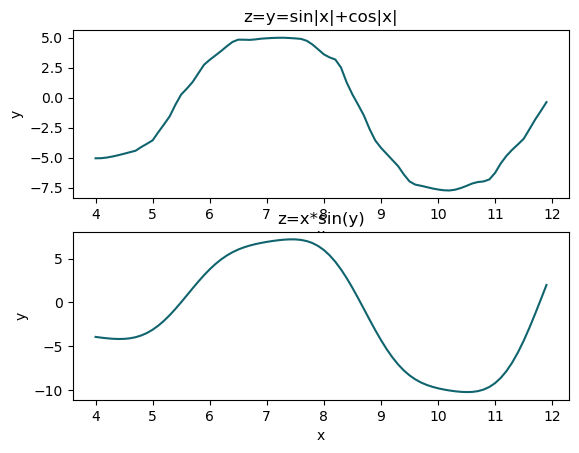

In [80]:
triangle_results = creation_of_membership(x, y, z)

Text(0.5, 1.0, 'Z function')

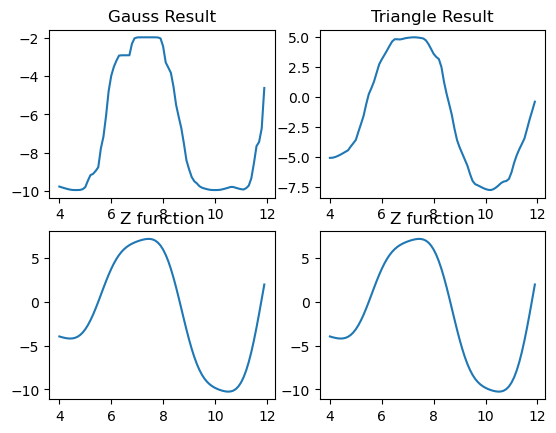

In [86]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x_values, gauss_result)
axs[0, 0].set_title('Gauss Result')
axs[0, 1].plot(x_values, triangle_results)
axs[0, 1].set_title('Triangle Result')
axs[1, 0].plot(x_values, z_values)
axs[1, 0].set_title('Z function')
axs[1, 1].plot(x_values, z_values)
axs[1, 1].set_title('Z function')

In [118]:
from sklearn.metrics import mean_absolute_error, r2_score

def mae_r2_score(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    
    print("Simulation quality:")
    print(f"Mean Absolute Error (MAE) = {mae}")
    print(f"Coefficient of Determination (R²) = {r2}")

In [240]:
mae_r2_score(z_values, gauss_result)

Simulation quality:
Mean Absolute Error (MAE) = 5.573630639331604
Coefficient of Determination (R²) = -0.12490072975573785


In [242]:
mae_r2_score(z_values, triangle_results)

Simulation quality:
Mean Absolute Error (MAE) = 1.4469944601707727
Coefficient of Determination (R²) = 0.9201384787238239


Accuracy Evaluation:
Mean Absolute Error (MAE):
The first simulation has a significantly larger error (5.57) compared to the second simulation (1.45). This indicates that the second model is closer to the true values on average.
Coefficient of Determination (R²):
The R² for the first simulation is negative (-0.12), which indicates a poor model. A negative R² means that the model performs worse than simply predicting the mean of the true values.
The R² for the second simulation is 0.92, which is very close to 1. This means the second model explains 92% of the variability in the data and makes accurate predictions.
Conclusion:
The second simulation is significantly more accurate than the first:
It has a smaller mean error (1.45 vs. 5.57).
It has a high R² score (0.92), showing that the model predicts the data with high precision.
The first simulation performs poorly, with both a high error and a negative R², indicating low predictive capability.

In [108]:
def create_and_print_rules_list_diagonal(df_names):
    rules = []
    
    # Ensure we're only considering square matrices (where number of rows == number of columns)
    n = min(len(df_names.index), len(df_names.columns))
    
    # Iterate through the diagonal elements
    for i in range(n):
        y_label = df_names.index[i]
        x_label = df_names.columns[i]
        
        # Get the corresponding output label from the diagonal of df_names
        z_label = df_names.iloc[i, i]
        
        if z_label:  # Only create a rule if there is a corresponding z label
            # Create a Rule object
            rule = control.Rule(antecedent=(x[x_label] & y[y_label]), consequent=z[z_label])
            rules.append(rule)

            # Print the rule in the specified format
            print(f"if (x is {x_label}) and (y is {y_label}) then (f is {z_label})")

    return rules

In [110]:
rules_diagonal_gauss = create_and_print_rules_list_diagonal(df_names_gauss)

if (x is mx1) and (y is my1) then (f is mf1)
if (x is mx2) and (y is my2) then (f is mf1)
if (x is mx3) and (y is my3) then (f is mf1)
if (x is mx4) and (y is my4) then (f is mf3)
if (x is mx5) and (y is my5) then (f is mf5)
if (x is mx6) and (y is my6) then (f is mf5)


<Figure size 1000x600 with 0 Axes>

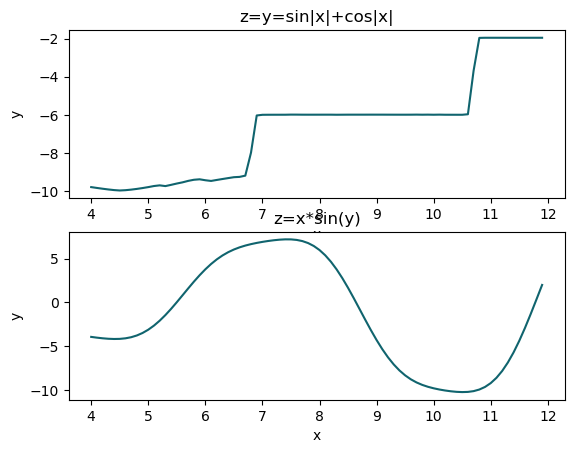

In [114]:
system = control.ControlSystem(rules_diagonal_gauss)

# Create simulation
simulation = control.ControlSystemSimulation(system)

# Store results from the simulation
diagonal_gauss_results = []

# Simulate for each combination of x and y values
for x_val, y_val in zip(x_values, y_values):
    simulation.input['x'] = x_val
    simulation.input['y'] = y_val
    simulation.compute()
    # Get output z
    output = simulation.output['z']
    diagonal_gauss_results.append(output)

# Plot results with subplot_graphs function
plot_script.subplot_graphs(x_values, [{'y': diagonal_gauss_results, 'label': 'z=y=sin|x|+cos|x|', 'color': '#10646e', 'linestyle': '-'},
                                      {'y': z_values, 'label': 'z=x*sin(y)', 'color': '#10646e', 'linestyle': '-'}])

In [124]:
rules_diagonal_triangle = create_and_print_rules_list_diagonal(df_names_triangle)

if (x is mx1) and (y is my1) then (f is mf3)
if (x is mx2) and (y is my2) then (f is mf3)
if (x is mx3) and (y is my3) then (f is mf3)
if (x is mx4) and (y is my4) then (f is mf6)
if (x is mx5) and (y is my5) then (f is mf8)
if (x is mx6) and (y is my6) then (f is mf8)


<Figure size 1000x600 with 0 Axes>

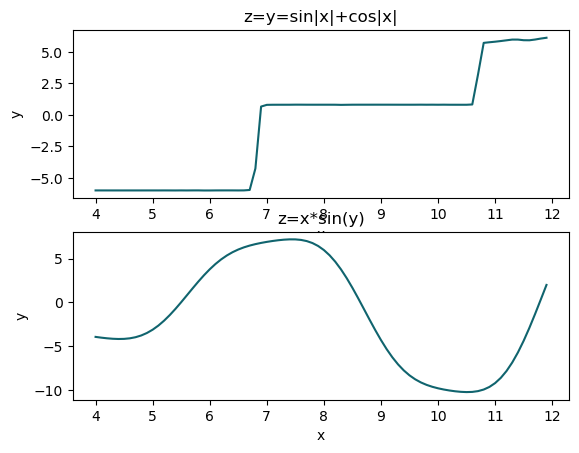

In [126]:
system = control.ControlSystem(rules_diagonal_triangle)

# Create simulation
simulation = control.ControlSystemSimulation(system)

# Store results from the simulation
diagonal_triangle_results = []

# Simulate for each combination of x and y values
for x_val, y_val in zip(x_values, y_values):
    simulation.input['x'] = x_val
    simulation.input['y'] = y_val
    simulation.compute()
    # Get output z
    output = simulation.output['z']
    diagonal_triangle_results.append(output)

# Plot results with subplot_graphs function
plot_script.subplot_graphs(x_values, [{'y': diagonal_triangle_results, 'label': 'z=y=sin|x|+cos|x|', 'color': '#10646e', 'linestyle': '-'},
                                      {'y': z_values, 'label': 'z=x*sin(y)', 'color': '#10646e', 'linestyle': '-'}])

In [119]:
mae_r2_score(z_values, diagonal_gauss_results)

Simulation quality:
Mean Absolute Error (MAE) = 7.708558393179844
Coefficient of Determination (R²) = -1.1543551614889052


In [128]:
mae_r2_score(z_values, diagonal_triangle_results)

Simulation quality:
Mean Absolute Error (MAE) = 7.30676760465802
Coefficient of Determination (R²) = -0.8948559625944197


1. Mean Absolute Error (MAE):
The Gauss diagonal rules (7.7086) show a slightly higher mean absolute error compared to the triangle rules (7.3068). This indicates that, on average, the triangle simulation has a smaller error per step.
Conclusion: The triangle rule performs better in terms of MAE, as it shows a lower error magnitude.

2. Coefficient of Determination (R²):
R² for the Gauss diagonal rules (-1.1544) and R² for the triangle diagonal rules (-0.8949). Since the R² values for both simulations are negative, it means neither model explains the data better than a simple horizontal line, i.e., the simulation is inadequate. However, the triangle rule shows a better approximation since its R² value is closer to zero.
Conclusion: Although both approaches exhibit poor simulation quality, the triangle rules provide a slightly better fit.

The triangle simulation performs better in both MAE and R² metrics. However, both approaches need improvement, as the negative R² values indicate weak model adequacy.